In [1]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
import scipy
from rdkit.Chem import PandasTools
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl
import seaborn as sns
from tdc.single_pred import HTS
from tdc.single_pred import ADME
from rdkit import DataStructs
from rdkit.Chem import AllChem, MolFromSmiles, Draw
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, average_precision_score
from xgboost import XGBClassifier

In [2]:

# list of cytochrome p-450 enzymes
cyps = ['CYP2C19', 'CYP2D6', 'CYP3A4', 'CYP1A2', 'CYP2C9', 'CYP23A4']
# fit ML Models for all the above enzymes and evaluate their results


In [35]:
def data_load_and_prep(cyp_name):
    """Load the data for given cyp enzyme and splits that data into train, validation and test

     Args:
         cyp_name: CPY 450 Enzyme Name.

     Returns:
         list of DataFrames: Train, Validation and Test Dataframes.
    """
    data = ADME(name = cyp_name+'_Veith')
    splits = data.get_split('scaffold')
    train_df, val_df, test_df = splits['train'], splits['valid'], splits['test']
    print(train_df.shape)
    return train_df, val_df, test_df


def compute_fingerprint(mol, r, nBits) -> np.ndarray:
    """Featurize Rdkit Mol into Morgan Fingerprint bit vectors.

     Args:
         mol: an Rdkit Mol object (representing a molecule).
         r: radius
         nBits: Bit Vector Length

     Returns:
         numpy.ndarray: A 1-D numpy array of the featurized molecule.
    """
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def process_df(df):
    """Process the Dataframe.

     Args:
         df: Dataframe to be processed

     Returns:
         df: Processed df.
         fingerprints: fingerprints array for all the molecules in the dataframe 
    """
    df = df.rename(columns={'Y':'Inhibition'})
    PandasTools.AddMoleculeColumnToFrame(df, "Drug", "Molecule")
    df = df.dropna()
    fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in df.Molecule])
    df['fingerprints'] = df['Molecule'].apply(compute_fingerprint, r=2, nBits=2048)

    return df, fingerprints
    
    
def fit_xgb_model(fingerprints,
                  target,
                  max_depth = 50,
                  n_estimators = 500
                 ):
    """Process the Dataframe.

     Args:
         fingerprints: Morgan Fingerprints ndarray for all the molecules in a dataframe
         target: A binary label vector
         max_depth: MAxmimum depth of a tree
         n_estimators: number of rounds for boosting 

     Returns:
         An XGBoost Binary Classification Model that provides the probability of a moelcules ability to inhibit CYP450 
    """
    # declare parameters
    params = {
                'objective':'binary:logistic',
                'max_depth': max_depth,
                'colsample_bytree' : 0.7,
                'sub_sample' : 0.5,
                'learning_rate': 0.05,
                'n_estimators':n_estimators,
                'eval_metric' : 'logloss'
            }
            
    # instantiate the classifier 
    xgb_clf = XGBClassifier(**params)
    # fit the classifier to the training data
    xgb_clf.fit(fingerprints, target)
    return xgb_clf


def validate_model(xgb_model,
                   fingerprints,
                   target,
                   name = 'test'):
    
    # make predictions on test data
    predictions = xgb_model.predict(fingerprints)
    accuracy = accuracy_score(target, predictions)
    precision = precision_score(target, predictions)
    recall = recall_score(target, predictions)
    print(name+' dataset\n')
    print('Accuracy : {0:0.4f}'. format(accuracy))
    print(f"Precision: {precision:.2f}")               
    print(f"Recall: {recall:.2f}")
    return predictions, accuracy, precision, recall

def roc_pr_curve(xgb_model,
              test_data_fp,
              target,
              curve = "roc",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             ):
    probs = xgb_model.predict_proba(test_data_fp)[:, 1]
    plt.figure(figsize=(5, 3))
    if curve == "roc":
        x, y, thresholds = roc_curve(target, probs)
        plot_data = auc(x, y)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    else:
        y, x, _ = precision_recall_curve(target, probs)
        plot_data = average_precision_score(target, probs)
    
    plt.plot(x, y, color='darkorange', lw=2, label= label % plot_data)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [4]:
# geat data for CYP3A4
train_3a4, val_3a4, test_3a4 = data_load_and_prep('CYP3A4')

Found local copy...
Loading...
Done!
100%|███████████████████████████████████| 12328/12328 [00:01<00:00, 7785.49it/s]

(8629, 3)


In [5]:
# check how data looks like
with pd.option_context('display.max_colwidth', None):
  display(train_3a4.head())

,Drug_ID,Drug,Y
0,6604143.0,NC(=O)C1=CN([C@@H]2O[C@@H](COP(=O)([O-])OP(=O)([O-])OC[C@@H]3O[C@H](n4cnc5c(N)ncnc54)[C@@H](OP(=O)([O-])[O-])[C@@H]3O)[C@H](O)[C@@H]2O)C=CC1.[Na+].[Na+].[Na+].[Na+],0
1,4577404.0,NS(=O)(=O)c1cccc2c1c([N+](=O)[O-])cc1nc([O-])c([O-])nc12,0
2,6098006.0,NS(=O)(=O)c1cccc2c1c([N+](=O)[O-])cc1nc([O-])c([O-])nc12.[Na+].[Na+],0
3,408613.0,COc1cc(CN2CCCCC2)cc2cc(C(=O)O)c(=O)oc12,0
4,9594267.0,CCOc1cc(/C=N/NC(=O)Cc2ccc(C(F)(F)F)cc2[N+](=O)[O-])c(Br)cc1OC,1


In [7]:
train_3a4, train_fingerprints_3a4 = process_df(train_3a4)
val_3a4, val_fingerprints_3a4 = process_df(test_3a4)
test_3a4, test_fingerprints_3a4 = process_df(test_3a4)

In [8]:
# list of columns in the dataframe
train_3a4.columns.tolist()

['Drug_ID', 'Drug', 'Inhibition', 'Molecule', 'fingerprints']

In [9]:
# check the first 100 elements in the fingerprints of the first molecule 
train_3a4['fingerprints'][1][1:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [10]:
# how many elements that are not zero in the first molecule fingerprint
sum(train_3a4['fingerprints'][1] > 0)

40

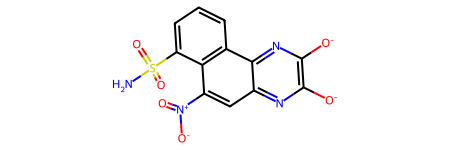

In [11]:
# check the structure of moecules
train_3a4['Molecule'][1]

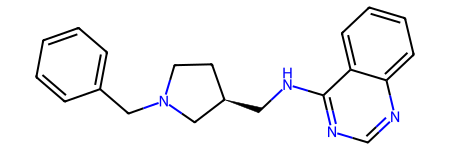

In [12]:
train_3a4['Molecule'][100]

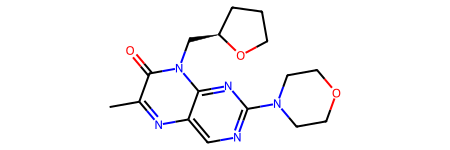

In [13]:
train_3a4['Molecule'][800]

In [14]:
# fit XGBoost model for CYP3A4

xgb_3a4 = fit_xgb_model(train_fingerprints_3a4,
                        train_3a4.Inhibition,
                        max_depth = 15,
                        n_estimators = 2000)

In [15]:
# Evaluate the model
metrics_val = validate_model(xgb_3a4,
                   val_fingerprints_3a4,
                   val_3a4.Inhibition,
                   name = 'val')

val dataset

Accuracy : 0.7864
Precision: 0.76
Recall: 0.76


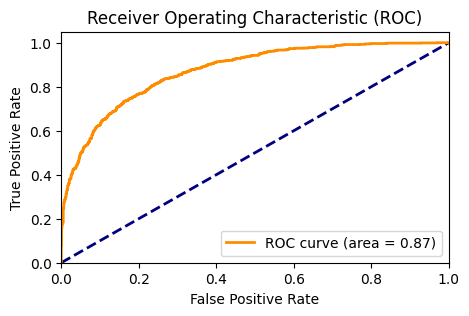

In [22]:
roc_pr_curve(xgb_3a4,
              val_fingerprints_3a4,
              val_3a4.Inhibition,
              curve = "roc",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

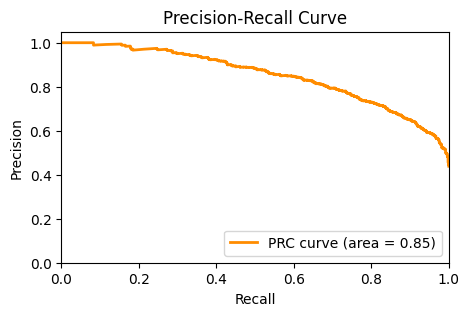

In [21]:
roc_pr_curve(xgb_3a4,
              val_fingerprints_3a4,
              val_3a4.Inhibition,
              curve = "pr",
              label = 'PRC curve (area = %0.2f)',
              x_label = 'Recall',
              y_label = 'Precision',
              title = 'Precision-Recall Curve'
             )

In [37]:
# geat data for CYP23A4
train_2c9, val_2c9, test_2c9 = data_load_and_prep('CYP2C9')
train_2c9, train_fingerprints_2c9 = process_df(train_2c9)
val_2c9, val_fingerprints_2c9 = process_df(val_2c9)
test_2c9, test_fingerprints_2c9 = process_df(test_2c9)

# fit XGBoost model for CYP3A4

xgb_2c9 = fit_xgb_model(train_fingerprints_2c9,
                        train_2c9.Inhibition,
                        max_depth = 15,
                        n_estimators = 2000)

# Evaluate the model
metrics_val_2c9 = validate_model(xgb_2c9,
                   val_fingerprints_2c9,
                   val_2c9.Inhibition,
                   name = 'val')



Found local copy...
Loading...
Done!
100%|███████████████████████████████████| 12092/12092 [00:01<00:00, 7638.41it/s]


(8464, 3)
val dataset

Accuracy : 0.7990
Precision: 0.71
Recall: 0.68


In [38]:
probs = xgb_2c9.predict_proba(val_fingerprints_2c9)[:, 1]
fpr, tpr, thresholds = roc_curve(val_2c9.Inhibition, probs)
auc(fpr, tpr)

0.8665468951538603

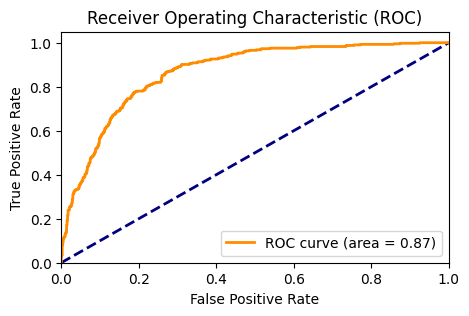

In [40]:
roc_pr_curve(xgb_2c9,
              val_fingerprints_2c9,
              val_2c9.Inhibition,
              curve = "roc",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

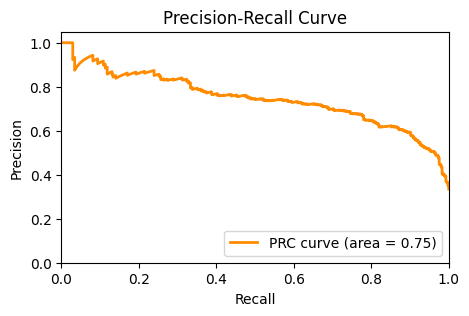

In [41]:
roc_pr_curve(xgb_2c9,
              val_fingerprints_2c9,
              val_2c9.Inhibition,
              curve = "pr",
              label = 'PRC curve (area = %0.2f)',
              x_label = 'Recall',
              y_label = 'Precision',
              title = 'Precision-Recall Curve'
             )

In [45]:
# geat data for CYP23A4
train_2c19, val_2c19, test_2c19 = data_load_and_prep('CYP2C19')
train_2c19, train_fingerprints_2c19 = process_df(train_2c19)
val_2c19, val_fingerprints_2c19 = process_df(val_2c19)
test_2c19, test_fingerprints_2c19 = process_df(test_2c19)

# fit XGBoost model for CYP3A4

xgb_2c19 = fit_xgb_model(train_fingerprints_2c19,
                        train_2c19.Inhibition,
                        max_depth = 15,
                        n_estimators = 2000)

# Evaluate the model
metrics_val_2c19 = validate_model(xgb_2c19,
                   val_fingerprints_2c19,
                   val_2c19.Inhibition,
                   name = 'val')


Found local copy...
Loading...
Done!
100%|███████████████████████████████████| 12665/12665 [00:01<00:00, 7666.90it/s]


(8865, 3)
val dataset

Accuracy : 0.7891
Precision: 0.78
Recall: 0.78


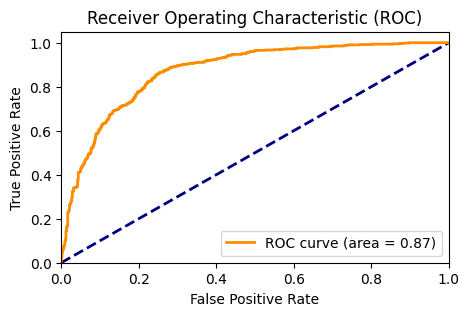

In [46]:
roc_pr_curve(xgb_2c19,
              val_fingerprints_2c19,
              val_2c19.Inhibition,
              curve = "roc",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

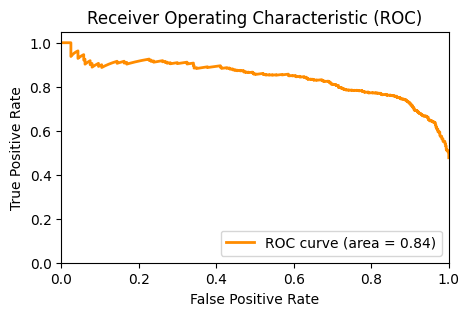

In [47]:
roc_pr_curve(xgb_2c19,
              val_fingerprints_2c19,
              val_2c19.Inhibition,
              curve = "pr",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

In [48]:
# geat data for CYP23A4
train_2d6, val_2d6, test_2d6 = data_load_and_prep('CYP2D6')
train_2d6, train_fingerprints_2d6 = process_df(train_2d6)
val_2d6, val_fingerprints_2d6 = process_df(val_2d6)
test_2d6, test_fingerprints_2d6 = process_df(test_2d6)

# fit XGBoost model for CYP3A4

xgb_2d6 = fit_xgb_model(train_fingerprints_2d6,
                        train_2d6.Inhibition,
                        max_depth = 15,
                        n_estimators = 2000)

# Evaluate the model
metrics_val_2d6 = validate_model(xgb_2d6,
                   val_fingerprints_2d6,
                   val_2d6.Inhibition,
                   name = 'val')


Found local copy...
Loading...
Done!
100%|███████████████████████████████████| 13130/13130 [00:01<00:00, 7687.41it/s]


(9191, 3)
val dataset

Accuracy : 0.8751
Precision: 0.71
Recall: 0.54


In [52]:
# prevalence
sum(val_2d6.Inhibition)/len(val_2d6.Inhibition)

0.1843107387661843

In [53]:
sum(val_2c19.Inhibition)/len(val_2c19.Inhibition)

0.47709320695102686

In [54]:
sum(val_3a4.Inhibition)/len(val_3a4.Inhibition)

0.43858937981353874

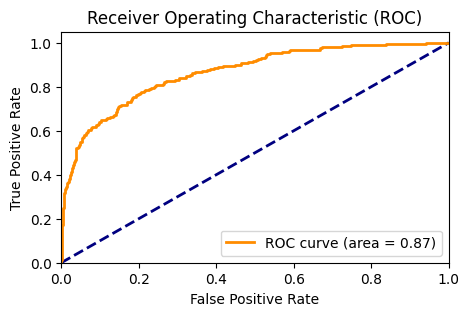

In [55]:
roc_pr_curve(xgb_2d6,
              val_fingerprints_2d6,
              val_2d6.Inhibition,
              curve = "roc",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

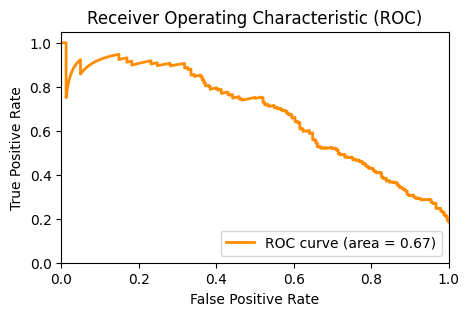

In [56]:
roc_pr_curve(xgb_2d6,
              val_fingerprints_2d6,
              val_2d6.Inhibition,
              curve = "pr",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

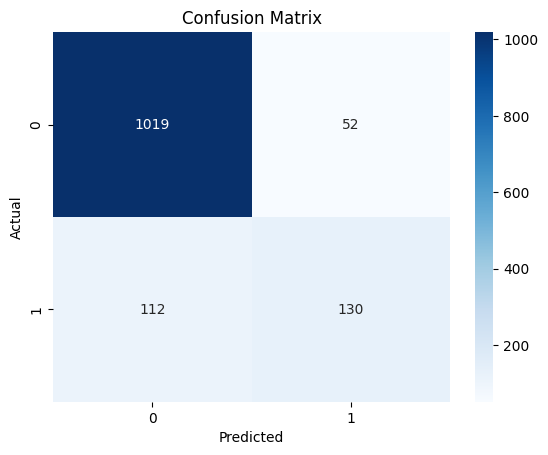

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_2d6.Inhibition, metrics_val_2d6[0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
# geat data for CYP23A4
train_1a2, val_1a2, test_1a2 = data_load_and_prep('CYP1A2')
train_1a2, train_fingerprints_1a2 = process_df(train_1a2)
val_1a2, val_fingerprints_1a2 = process_df(val_1a2)
test_1a2, test_fingerprints_1a2 = process_df(test_1a2)

# fit XGBoost model for CYP3A4

xgb_1a2 = fit_xgb_model(train_fingerprints_1a2,
                        train_1a2.Inhibition,
                        max_depth = 15,
                        n_estimators = 2000)

# Evaluate the model
metrics_val_1a2 = validate_model(xgb_1a2,
                   val_fingerprints_1a2,
                   val_1a2.Inhibition,
                   name = 'val')


Found local copy...
Loading...
Done!
100%|███████████████████████████████████| 12579/12579 [00:01<00:00, 7828.43it/s]


(8805, 3)
val dataset

Accuracy : 0.8258
Precision: 0.83
Recall: 0.82


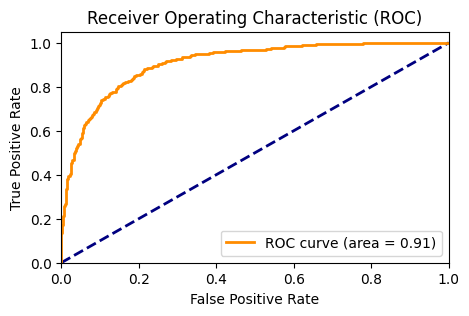

In [59]:
roc_pr_curve(xgb_1a2,
              val_fingerprints_1a2,
              val_1a2.Inhibition,
              curve = "roc",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

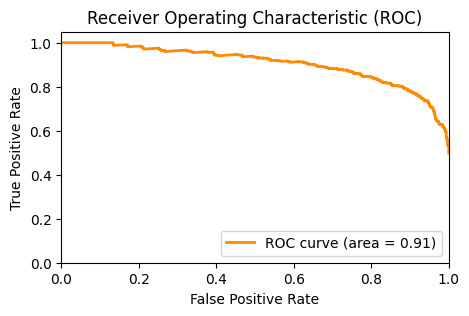

In [60]:
roc_pr_curve(xgb_1a2,
              val_fingerprints_1a2,
              val_1a2.Inhibition,
              curve = "pr",
              label = 'ROC curve (area = %0.2f)',
              x_label = 'False Positive Rate',
              y_label = 'True Positive Rate',
              title = 'Receiver Operating Characteristic (ROC)'
             )

In [62]:
sum(val_1a2.Inhibition)/len(val_1a2.Inhibition)

0.49801113762927607

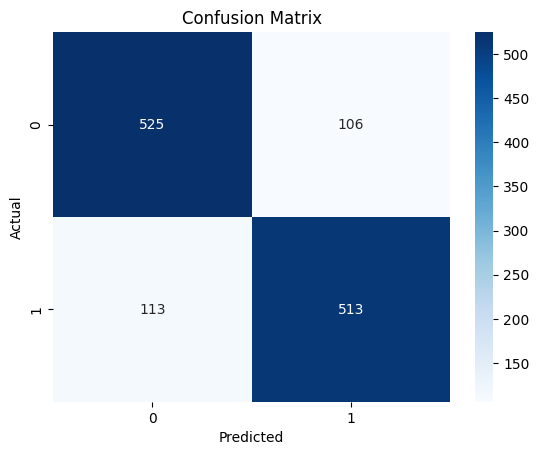

In [63]:
cm = confusion_matrix(val_1a2.Inhibition, metrics_val_1a2[0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [66]:
# Evaluate the model on test data
metrics_test_1a2 = validate_model(xgb_1a2,
                   test_fingerprints_1a2,
                   test_1a2.Inhibition,
                   name = 'test')


test dataset

Accuracy : 0.8498
Precision: 0.87
Recall: 0.83


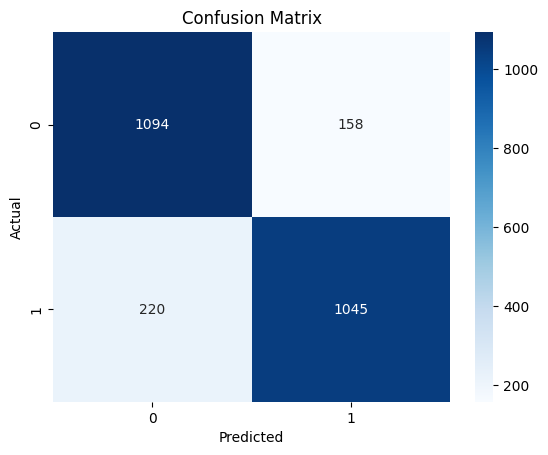

In [67]:
cm = confusion_matrix(test_1a2.Inhibition, metrics_test_1a2[0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [68]:
# Evaluate the model on test data
metrics_test_2c19 = validate_model(xgb_2c19,
                   test_fingerprints_2c19,
                   test_2c19.Inhibition,
                   name = 'test')

test dataset

Accuracy : 0.7952
Precision: 0.78
Recall: 0.81


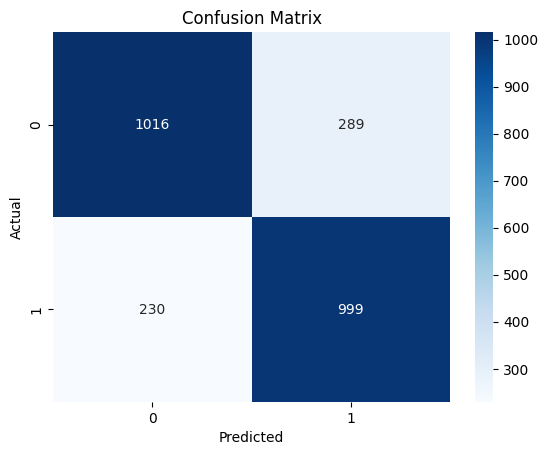

In [69]:
cm = confusion_matrix(test_2c19.Inhibition, metrics_test_2c19[0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [70]:
# Evaluate the model on test data
metrics_test_23a4 = validate_model(xgb_23a4,
                   test_fingerprints_23a4,
                   test_23a4.Inhibition,
                   name = 'test')

test dataset

Accuracy : 0.7864
Precision: 0.76
Recall: 0.76


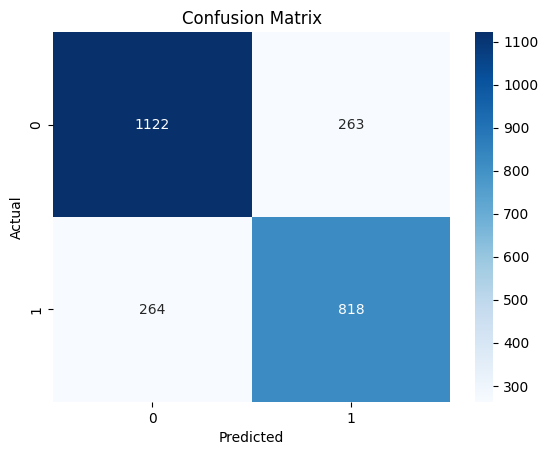

In [71]:
cm = confusion_matrix(test_23a4.Inhibition, metrics_test_23a4[0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [72]:
# Evaluate the model on test data
metrics_test_2c9 = validate_model(xgb_2c9,
                   test_fingerprints_2c9,
                   test_2c9.Inhibition,
                   name = 'test')

test dataset

Accuracy : 0.8123
Precision: 0.73
Recall: 0.65


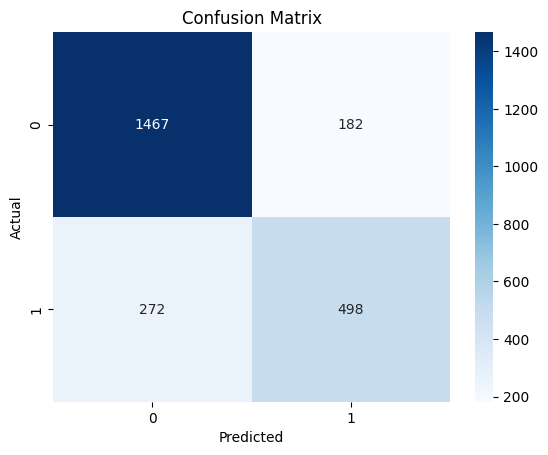

In [73]:
cm = confusion_matrix(test_2c9.Inhibition, metrics_test_2c9[0])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [227]:
train_fp_2c19_df = pd.DataFrame(train_fp_2c19)

In [229]:
train_fp_2c19_df = pd.concat([train_fp_2c19_df, train_2c19[['MolWt', 'logP', 'NumHAcceptors', 'NumHDonors']]], axis = 1)

In [230]:
train_fp_2c19_df.shape

(8865, 2052)

In [231]:
val_fp_2c19_df = pd.concat([pd.DataFrame(val_fp_2c19), val_2c19[['MolWt', 'logP', 'NumHAcceptors', 'NumHDonors']]], axis = 1)
test_fp_2c19_df = pd.concat([pd.DataFrame(val_fp_2c19), test_2c19[['MolWt', 'logP', 'NumHAcceptors', 'NumHDonors']]], axis = 1)